# Hamilton equation of motion

***

The Hamilton equations of motion derive from a yet more fundamental law of physics -- the principle of least action. This states that a trajectory is physical if and only of it minimizes the action.

The action is given as
$$S = \int d\tau$$
and the principle of least action requires that
$$\delta S = 0$$

- Fundamentalize Hamiltonian with Hamilton equations of motion
- Poisson bracket
- Stationary states

In [ ]:
from sympy import pi
from sympy import init_session, init_printing
from sympy.integrals.trigonometry import trigintegrate

init_session()
init_printing()

In [ ]:
C, R, E, V          = symbols('C, R, E, V', real=True, positive=True)
c, e, pi, zs, zu    = symbols('c, e, pi, z_s, z_u', real=True, positive=True)
h, p0               = symbols('h, p_0', real=True, positive=True)
alpha, gamma, eta   = symbols('alpha, gamma, eta', real=True, positive=True)
z, delta            = symbols('z, delta', real=True, positive=True)
# H, ps                   = symbols('H, ps', cls=Function)

In [ ]:
def beta(gamma):
    return sqrt(1 - gamma**-2)
simplify(solve(p0 - m*gamma*beta(gamma)*c, gamma))

In [ ]:
def v(z):
    return V * cos(h*z/R)
v(z)

In [ ]:
# zmax = C/(2*h)
def H(z, delta):
    return (-1/2 * eta*beta*c*delta**2
        + e*V/(2*pi*p0*h) * ((cos(h*z/R)-cos(pi-h*zs/R)) + (h*z/R-pi+h*zs/R)*sin(h*zs/R)))
H(z, delta)

# NumPy evaluations

In [92]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.constants import e, c, m_p

import curve_tools as cv

## Field and voltage functions

In [184]:
def get_zsfp_and_zufp(f):

    phi_stable = 0
    # This does not work as counting will be violated for large accelerations
    zz = np.linspace(phi_stable - 1.1*zmax, phi_stable + 1.1*zmax) 
    # Safer
    zz = np.linspace(phi_stable - 1.5*zmax, phi_stable + 1.5*zmax) 
    z0 = np.atleast_1d(cv.zero_crossings(f, zz))[0]
    
    z0odd = z0[1::2]
    z0even = z0[::2]
    
    if len(z0) == 1:
        return z0, z0
    
    if eta*dp > 0:
        z_sfp, z_ufp = z0odd, z0even
    else:
        z_sfp, z_ufp = z0even, z0odd
        
    return z_sfp, z_ufp


def zufp_separatrix(f):

    z_sfp, z_ufp = get_zsfp_and_zufp(f)
    
    if eta*dp > 0:
        return z_ufp[-1]
    else:
        return z_ufp[0]

In [185]:
def efield(V, h, dphi, dp=0):
    def f(z):
        return e/(p0*C) * reduce(
            lambda x, y: x+y, [V[i]*np.sin(h[i]*z/R + dphi[i]) for i in xrange(len(V))]) - dp*beta*c/C
    return f

def voltage(V, h, dphi, dp=0, ef=None):
    def vf(z):
        return e/(p0*C) * reduce(
            lambda x, y: x+y, [R/h[i] * V[i]*np.cos(h[i]*z/R + dphi[i]) for i in xrange(len(V))])

    if dp:
        zmax = zufp_separatrix(ef)

        def f(z):
            return vf(z) - vf(zmax) + dp*beta*c/C * (z - zmax)
        return f

    else:
        return vf

def hamiltonian(z, dp, vf):
    return -1/2*eta*beta*c*dp**2 + vf(z)

def eqH(vf, Hc):
    def f(z):
        return np.sqrt(( 2./(eta*beta*c) * (vf(z) - Hc)))

    return f

## Plot & play

In [186]:
%matplotlib inline

In [208]:
# Machine
C      = 6911.
R      = C/(2*np.pi)

p0     = 26e9 * e/c
gamma  = (1 + (p0/(m_p*c))**2)

alpha  = 1/18**2
eta    = alpha - 1/gamma**2
V      = [4e6, -20e5]
h      = [4620, 18480]
dphi   = [0, 0]

# Acceleration
beta          = np.sqrt(1-1/gamma**2)
T0            = C/(beta*c)
normalisation = 1/C * e/p0 * T0
dp            = 2e6 * normalisation

In [209]:
zmax   = C/min(h)/2.
zz = np.linspace(-1.2*zmax, 1.2*zmax, 1000)
pp = np.linspace(-5e-3, 5e-3, 1000)
ZZ, PP = np.meshgrid(zz, pp)

ef = efield(V, h, dphi, dp)
vf = voltage(V, h, dphi, dp, ef)
hh = hamiltonian(ZZ, PP, vf)
hc = eqH(vf, 0)

zsfp, zufp = get_zsfp_and_zufp(ef)
z0 = np.array([z for z in zsfp] + [z for z in zufp])

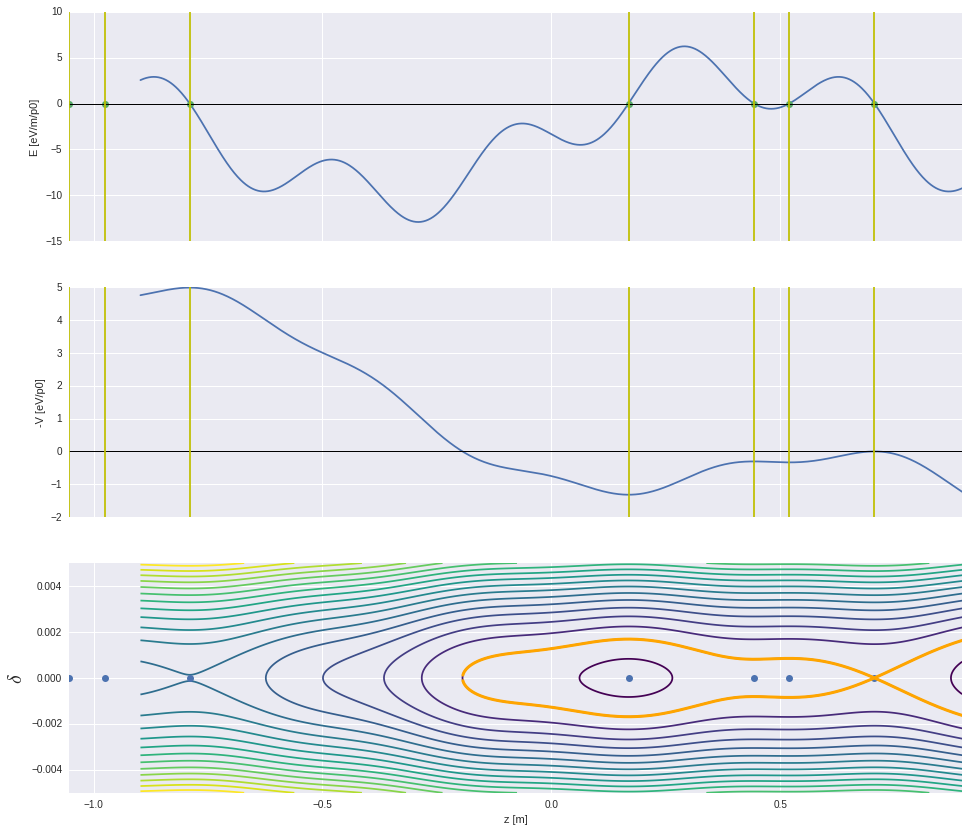

In [210]:
fig1, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,14), sharex=True)

ax1.plot(zz, ef(zz))
ax1.plot(z0, 0*z0, 'o')
ax1.axhline(0, c='k', lw=1)
[ax1.axvline(z, c='y') for z in z0]
ax1.set_ylabel('E [eV/m/p0]')

ax2.plot(zz, -vf(zz))
ax2.axhline(0, c='k', lw=1)
[ax2.axvline(z, c='y') for z in z0]
ax2.set_ylabel('-V [eV/p0]')

ax3.plot(z0, 0*z0, 'o')
ax3.plot(zz, +hc(zz), c='orange', lw=3)
ax3.plot(zz, -hc(zz), c='orange', lw=3)
ax3.contour(ZZ, PP, hh, 20, cmap=plt.cm.viridis_r)
ax3.set_xlabel('z [m]')
ax3.set_ylabel('$\delta$', fontsize=20)

plt.show()

# [ax.axhline(0, c='r', ls='--', lw=2) for ax in [ax1, ax2]]
# [ax.axvline(p, c=cl, ls='--', lw=2) for p, cl in zip(ap, ac) for ax in [ax1, ax2]]
# [ax1.plot(p, Es(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# [ax2.plot(p, -Vs(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# [ax3.plot(p, 0, '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# # [ax3.annotate(t, (p,0), (-40, -70), textcoords='offset points', color=cl, fontsize=22,
# #               bbox=dict(boxstyle="round", fc="1"),
# #               arrowprops=dict(arrowstyle="fancy",
# #                               fc="0.6", ec="none",
# #                               connectionstyle="angle3,angleA=0,angleB=-90")) for t, p, cl in zip(at, ap, ac)]
# ax3.plot(ap[1], hc(ap[1]), 'x', c='r', ms=8, mew=2)

In [ ]:
ap = []
at = ['$z_u$', '$z_s$', '$z_r$']
ac = ['b', 'orange', 'b']
try:
    ap.append(vx0[0])
except IndexError:
    ap.append(ex0[0])
ap.append(zs)
ap.append(ex0[-1])
ap.append(np.pi-zs)

In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10), sharex=True)

ax1.plot(zz, ea(zz), 'g', lw=2);
ax1.set_ylabel('E [eV/m/p0]')
ax1.grid()

ax2.plot(zz, -va(zz), 'brown', lw=2);
ax2.set_ylabel('-V [eV/p0]')
ax2.grid()

ax3.contour(ZZ, PP, hh, 40);
ax3.contour(ZZ, PP, hh, levels=[0]);
ax3.plot(zz, +hc(zz), c='purple', lw=2);
ax3.plot(zz, -hc(zz), c='purple', lw=2);
ax3.set_xlabel('z [m]')
ax3.set_ylabel('$\delta$', fontsize=20)

[ax.axhline(0, c='r', ls='--', lw=2) for ax in [ax1, ax2]]
[ax.axvline(p, c=cl, ls='--', lw=2) for p, cl in zip(ap, ac) for ax in [ax1, ax2]]
[ax1.plot(p, Es(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
[ax2.plot(p, -Vs(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
[ax3.plot(p, 0, '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# [ax3.annotate(t, (p,0), (-40, -70), textcoords='offset points', color=cl, fontsize=22,
#               bbox=dict(boxstyle="round", fc="1"),
#               arrowprops=dict(arrowstyle="fancy",
#                               fc="0.6", ec="none",
#                               connectionstyle="angle3,angleA=0,angleB=-90")) for t, p, cl in zip(at, ap, ac)]
ax3.plot(ap[1], hc(ap[1]), 'x', c='r', ms=8, mew=2)
# ax3.annotate(r'$\delta_{max}$', (ap[1], hc(ap[1])), (50, 25), textcoords='offset points', color='r', fontsize=22,
#              bbox=dict(boxstyle="round", fc="1"),
#              arrowprops=dict(arrowstyle="fancy",
#                              fc="0.6", ec="none",
#                              connectionstyle="angle3,angleA=0,angleB=-90"))

plt.tight_layout()
# plt.savefig('bucket_multiple_accelerating.png', dpi=300)
# plt.savefig('bucket_accelerating.png', dpi=200)
plt.show()